# Davidson Dataset Hate Speech Detection

## Imports and data loading

In [163]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

from sklearn.model_selection import train_test_split
from sklearn.utils import class_weight

import tensorflow as tf
pad_sequences = tf.keras.preprocessing.sequence.pad_sequences
tokenizer = tf.keras.preprocessing.text.Tokenizer()
Input = tf.keras.layers.Input
Embedding = tf.keras.layers.Embedding
Dense = tf.keras.layers.Dense
Concatenate = tf.keras.layers.Concatenate
Model = tf.keras.Model
simpleRNN = tf.keras.layers.SimpleRNN
LSTM = tf.keras.layers.LSTM
GRU = tf.keras.layers.GRU
dropout = tf.keras.layers.Dropout

import nltk
from nltk.corpus import stopwords
""" import ssl

try:
    _create_unverified_https_context = ssl._create_unverified_context
except AttributeError:y

    pass
else:
    ssl._create_default_https_context = _create_unverified_https_context """

nltk.download('stopwords')
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')
wnl = WordNetLemmatizer()

import re
import numpy as np

from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/alkakumari/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/alkakumari/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


Data definition:

count = number of CrowdFlower users who coded each tweet (min is 3, sometimes more users coded a tweet when judgments were determined to be unreliable by CF).

hate_speech = number of CF users who judged the tweet to be hate speech.

offensive_language = number of CF users who judged the tweet to be offensive.

neither = number of CF users who judged the tweet to be neither offensive nor non-offensive.

class = class label for majority of CF users. 0 - hate speech 1 - offensive language 2 - neither

In [164]:
david_df = pd.read_csv('data/davidson.csv')
david_df.head()

,Unnamed: 0,count,hate_speech,offensive_language,neither,class,tweet
0,0,3,0,0,3,2,!!! RT @mayasolovely: As a woman you shouldn't...
1,1,3,0,3,0,1,!!!!! RT @mleew17: boy dats cold...tyga dwn ba...
2,2,3,0,3,0,1,!!!!!!! RT @UrKindOfBrand Dawg!!!! RT @80sbaby...
3,3,3,0,2,1,1,!!!!!!!!! RT @C_G_Anderson: @viva_based she lo...
4,4,6,0,6,0,1,!!!!!!!!!!!!! RT @ShenikaRoberts: The shit you...


## EDA and Preprocess definitions

There are no null values in the dataset

In [165]:
david_df.isnull().sum()

Unnamed: 0            0
count                 0
hate_speech           0
offensive_language    0
neither               0
class                 0
tweet                 0
dtype: int64

In [166]:
stopwords = stopwords.words('english')
stopwords.append('&amp;') # &amp; means and
def clean(df):
    df['tweet'] = df['tweet'].apply(lambda x: x.lower()) #lowercase
    df['tweet'] = df['tweet'].apply(lambda x: ' '.join([word for word in x.split() if word not in (stopwords)])) #stopwords removal
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'@[A-Za-z0-9]*', 'MENTION', x)) #replace all @mentions to 'MENTION'
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'https?:\/\/(www\.)?[-a-zA-Z0-9@:%._\+~#=]{1,256}\.[a-zA-Z0-9()]{1,6}\b([-a-zA-Z0-9()@:%_\+.~#?&//=]*)', 'URL', x)) #replace all urls to 'URL'
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'[^\w\s]', '', x)) #remove punctuation
    punct = '!"$%&\'()*+,-./:;<=>?[\\]^_{|}~'
    df['tweet'] = df['tweet'].apply(lambda x: ''.join(ch for ch in x if ch not in set(punct)))
    df['tweet'] = df['tweet'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='a') for word in x.split()])) #lemmatize on the basis of adjectives
    df['tweet'] = df['tweet'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='v') for word in x.split()])) #lemmatize on the basis of verbs
    df['tweet'] = df['tweet'].apply(lambda x: ' '.join([wnl.lemmatize(word, pos='n') for word in x.split()])) #lemmatize on the basis of noun
    df['tweet'] = df['tweet'].apply(lambda x: re.sub(r'\bRT\b', '', x)) #remove RT
    return df

In [167]:
MAX_SEQ_LEN = 25
def tokenize(df):
    df['tweet'] = tokenizer.texts_to_sequences(df['tweet'])
    vocab_size = len(tokenizer.word_index) + 1
    #print('Vocabulary size: {}'.format(vocab_size))
    padded_tweet = pad_sequences(df['tweet'].tolist(), padding='post', maxlen=MAX_SEQ_LEN)
    return padded_tweet, vocab_size

def preprocess(df):
    df = clean(df)
    df, vocab_size = tokenize(df)
    return df, vocab_size

## Splitting the dataset and calling preprocessing functions

1. Tokenizer is fit on the training data only, which is used to transform both the training and test data to maintain the integrity of the val set as truly unseen data. This avoids data leakage.

In [168]:
X = david_df.drop(columns=['class'])
Y = david_df['class']
X_train, X_val, Y_train, Y_val = train_test_split(X, Y, test_size=0.2, random_state=54)
print("Training Shape:", X_train.shape)
print("Validation Shape:", X_val.shape) 

Training Shape: (19826, 6)
Validation Shape: (4957, 6)


Even after splitting the dataset, the distribution, although imbalanced, remains more or less consistent throughout original, train, val and test dataset. Hence, this splitting is correct.

<Figure size 640x480 with 0 Axes>

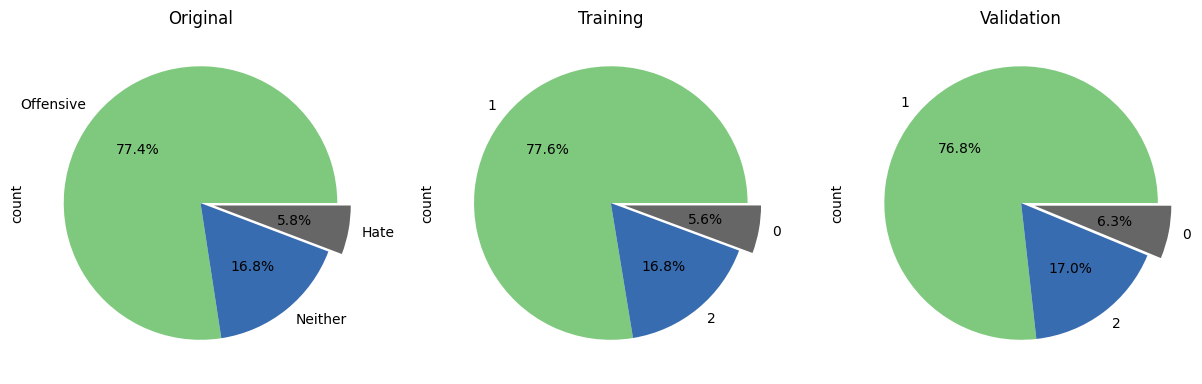

In [169]:
plt.suptitle('Class Distribution')
plt.figure(figsize=(15, 5))
explode = (0, 0, 0.1)
plt.subplot(1, 3, 1)
david_df['class_labels'] = david_df['class'].map({0: 'Hate', 1: 'Offensive', 2: 'Neither'})
david_df['class_labels'].value_counts().plot(kind='pie', title='Original', colormap='Accent', 
                                      autopct='%1.1f%%',
                                      explode=explode,
                                      )
plt.subplot(1, 3, 2)
Y_train.value_counts().plot.pie(title='Training', colormap='Accent', autopct='%1.1f%%',
                                explode=explode)
plt.subplot(1, 3, 3)
Y_val.value_counts().plot.pie(title='Validation', colormap='Accent', autopct='%1.1f%%',
                                explode=explode)
plt.show()
david_df.drop(columns=['class_labels'], inplace=True)

In [170]:
tokenizer.fit_on_texts(X_train['tweet'])
X_train, vocab_size = preprocess(X_train)
X_val, _ = preprocess(X_val)

In [171]:
# import os
# import requests
# import zipfile

# # Define the URL for the GloVe embeddings
# glove_url = "http://nlp.stanford.edu/data/glove.twitter.27B.zip"
# glove_zip_file = "glove.twitter.27B.zip"

# # Download the embeddings
# response = requests.get(glove_url, stream=True)
# with open(glove_zip_file, "wb") as file:
#     for chunk in response.iter_content(chunk_size=128):
#         file.write(chunk)

# # Extract the embeddings
# with zipfile.ZipFile(glove_zip_file, "r") as zip_ref:
#     zip_ref.extractall("glove_embeddings")


In [172]:
word_index = tokenizer.word_index
embedding_index = {}
with open('glove_embeddings/glove.twitter.27B.200d.txt', 'r', encoding='utf-8') as f:
    for line in f:
        values = line.split()
        word = values[0]
        coefs = np.asarray(values[1:], dtype='float32')
        embedding_index[word] = coefs
# Create embedding matrix
embedding_dim = 200
embedding_matrix = np.zeros((len(word_index) + 1, embedding_dim))
for word, i in word_index.items():
    embedding_vector = embedding_index.get(word)
    if embedding_vector is not None:
        embedding_matrix[i] = embedding_vector

In [173]:
class_weights = class_weight.compute_class_weight('balanced', classes=np.unique(Y_train), y=Y_train.astype(int))
class_weights = dict(enumerate(class_weights))
#If class weight is used, y needs to be one-hot encoded
Y_train_encoded = tf.keras.utils.to_categorical(Y_train, num_classes=3)
Y_val_encoded = tf.keras.utils.to_categorical(Y_val, num_classes=3)

## Baseline Models: Simple_RNN, LSTM and GRU

### Models

In [106]:
learning_rate = 0.00003

In [70]:
def model_LSTM(vocab_size, input_length=MAX_SEQ_LEN):
    text_input = Input(shape=(input_length,), name='text_input')
    x = Embedding(input_dim=vocab_size+1, output_dim=128, input_length=input_length)(text_input)
    x = LSTM(500, return_sequences=True)(x)
    x = dropout(0.8)(x)
    x = LSTM(300)(x)
    x = dropout(0.5)(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[text_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model


In [85]:
def model_RNN(vocab_size, input_length=MAX_SEQ_LEN):
    text_input = Input(shape=(input_length,), name='text_input')
    x = Embedding(input_dim=vocab_size+1, output_dim=128, input_length=MAX_SEQ_LEN)(text_input)
    x = simpleRNN(500)(x)
    x = dropout(0.8)(x)
    #add_input = Input(shape=(4,), name='additional_input')
    #x = Concatenate()([x, add_input])
    #x = Dense(64, activation='relu')(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[text_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [121]:
def model_GRU(vocab_size, input_length=MAX_SEQ_LEN):
    learning_rate = 0.00001
    text_input = Input(shape=(input_length,), name='text_input')
    x = Embedding(input_dim=vocab_size+1, output_dim=128, input_length=MAX_SEQ_LEN)(text_input)
    x = GRU(500)(x)
    x = dropout(0.8)(x)
    #add_input = Input(shape=(4,), name='additional_input')
    #x = Concatenate()([x, add_input])
    #x = Dense(64, activation='relu')(x)
    output = Dense(3, activation='softmax')(x)
    model = Model(inputs=[text_input], outputs=output)
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [174]:
def novel_model(vocab_size, input_length=MAX_SEQ_LEN, learning_rate=0.00003):
    Bidirectional = tf.keras.layers.Bidirectional
    model = tf.keras.Sequential()
    model.add(Embedding(input_dim=vocab_size, 
                        output_dim=200, 
                        weights=[embedding_matrix], 
                        input_length=input_length, 
                        trainable=False))
    model.add(Bidirectional(GRU(40, activation='relu', return_sequences=True, name='BiDirectionalGRUlayer'))) #GRU layer with 40 units
    model.add(dropout(0.4)) #Dropout layer to prevent overfitting
    model.add(Bidirectional(LSTM(20, recurrent_activation='relu', return_sequences=True))) #LSTM layer with 20 units
    model.add(dropout(0.4)) #Dropout layer to prevent overfitting
    model.add(Dense(15)) #Dense layer with 16 units and relu activation function
    model.add(dropout(0.4)) #Dropout layer to prevent overfitting
    model.add(simpleRNN(10)) #SimpleRNN layer with 10 units
    model.add(dropout(0.4)) #Dropout layer to prevent overfitting
    model.add(Dense(10)) #Dense layer with 16 units and relu activation function
    model.add(Dense(3, activation='softmax')) #Output layer with 3 units and softmax activation function
    optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate, use_ema=True, ema_momentum=0.9)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])
    return model

### Train and Test definitions

In [175]:
def train(model, X_train, Y_train, X_val, Y_val, epochs=100, batch_size=64):
      callback = tf.keras.callbacks.EarlyStopping(monitor='val_loss',
                                                      patience=6,
                                                      restore_best_weights=True)
      history = model.fit(X_train, Y_train, 
            validation_data=(X_val, Y_val), 
            epochs=epochs, batch_size=batch_size, 
            class_weight=class_weights,
            callbacks=callback,
            verbose=2)
      print("\n\n****************************\n\n")
      print("Model trained successfully")
      pred = model.predict(X_val, batch_size=batch_size, verbose=1, steps=None)
      y_true = np.argmax(Y_val, axis=1)
      y_pred = np.argmax(pred, axis=1)
      precision = precision_score(y_true, y_pred, average='weighted')
      recall = recall_score(y_true, y_pred, average='weighted')
      f1 = f1_score(y_true, y_pred, average='weighted')
      # Calculate AUC and plot ROC curve
      if Y_val.shape[1] == 2:  # Binary classification case
        auc = roc_auc_score(Y_val[:, 1], pred[:, 1])
        fpr, tpr, _ = roc_curve(Y_val[:, 1], pred[:, 1])
      else:  # Multi-class case (one-vs-rest approach)
        auc = roc_auc_score(Y_val, pred, multi_class='ovr', average='weighted')
        fpr, tpr, _ = roc_curve(Y_val.ravel(), pred.ravel())
    
      print("AUC: ", auc)
      print("Precision: ", precision, "Recall: ", recall, "F1 Score: ", f1)
      print("Validation Accuracy: ", model.evaluate(X_val, Y_val, batch_size=batch_size, verbose=1))
      
      # Plot ROC curve
      plt.figure(figsize=(8, 6))
      plt.plot(fpr, tpr, color='blue', lw=2, label=f'ROC curve (AUC = {auc:.2f})')
      plt.plot([0, 1], [0, 1], color='gray', linestyle='--')
      plt.xlim([0.0, 1.0])
      plt.ylim([0.0, 1.05])
      plt.xlabel('False Positive Rate')
      plt.ylabel('True Positive Rate')
      plt.title('Receiver Operating Characteristic (ROC) Curve')
      plt.legend(loc='lower right')
      plt.show()
      
      return history

In [176]:
def evaluate_model(history):
    train_accuracy = history.history['accuracy']
    val_accuracy = history.history['val_accuracy']
    train_loss = history.history['loss']
    val_loss = history.history['val_loss']
    
    plt.figure(figsize=(20, 6))

    plt.subplot(1, 2, 1)
    plt.plot(range(0, len(train_accuracy)), train_accuracy, 'b-', linewidth=2, label='Training Accuracy')
    plt.plot(range(0, len(val_accuracy)), val_accuracy, 'r-', linewidth=2, label='Validation Accuracy')
    plt.title('Training & validation accuracy over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend(loc='best')

    plt.subplot(1, 2, 2)
    plt.plot(range(0, len(train_loss)), train_loss, 'b-', linewidth=2, label='Training Loss')
    plt.plot(range(0, len(val_loss)), val_loss, 'r-', linewidth=2, label='Validation Loss')
    plt.title('Training & validation loss over epochs')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend(loc='best')

    plt.show()

### Training of BaseLine Models

In [72]:
m = model_LSTM(vocab_size)
history_LSTM = train(m, X_train, Y_train_encoded, X_val, Y_val_encoded, epochs=100, batch_size=512) 

Epoch 1/100
39/39 - 30s - 769ms/step - accuracy: 0.6356 - loss: 0.9446 - val_accuracy: 0.8094 - val_loss: 0.6290
Epoch 2/100
39/39 - 28s - 719ms/step - accuracy: 0.7807 - loss: 0.6549 - val_accuracy: 0.7751 - val_loss: 0.7712
Epoch 3/100
39/39 - 28s - 723ms/step - accuracy: 0.8222 - loss: 0.4833 - val_accuracy: 0.8102 - val_loss: 0.5565
Epoch 4/100
39/39 - 28s - 714ms/step - accuracy: 0.8577 - loss: 0.3517 - val_accuracy: 0.8324 - val_loss: 0.4735
Epoch 5/100
39/39 - 29s - 746ms/step - accuracy: 0.8783 - loss: 0.2569 - val_accuracy: 0.8509 - val_loss: 0.4476
Epoch 6/100
39/39 - 28s - 720ms/step - accuracy: 0.9020 - loss: 0.2057 - val_accuracy: 0.8186 - val_loss: 0.5566
Epoch 7/100
39/39 - 28s - 718ms/step - accuracy: 0.9067 - loss: 0.1776 - val_accuracy: 0.7381 - val_loss: 0.6565
Epoch 8/100
39/39 - 28s - 719ms/step - accuracy: 0.9218 - loss: 0.1766 - val_accuracy: 0.8366 - val_loss: 0.5014
Epoch 9/100
39/39 - 28s - 723ms/step - accuracy: 0.9322 - loss: 0.1442 - val_accuracy: 0.8293 - 

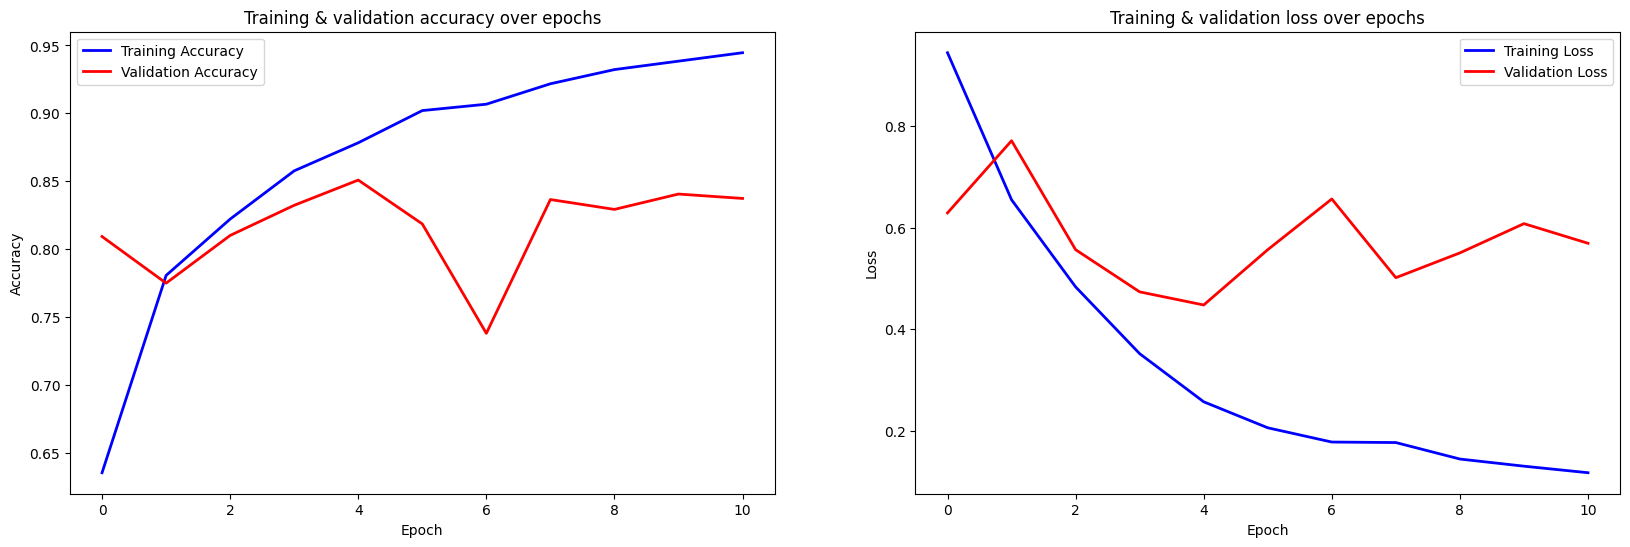

In [73]:
evaluate_model(history_LSTM)

In [88]:
m = model_RNN(vocab_size, input_length=MAX_SEQ_LEN)
history_RNN = train(m, X_train, Y_train_encoded, X_val, Y_val_encoded, epochs=100, batch_size=512) 

Epoch 1/100
39/39 - 6s - 143ms/step - accuracy: 0.4216 - loss: 1.0912 - val_accuracy: 0.5649 - val_loss: 1.0235
Epoch 2/100
39/39 - 5s - 120ms/step - accuracy: 0.6388 - loss: 0.9481 - val_accuracy: 0.7293 - val_loss: 0.7468
Epoch 3/100
39/39 - 4s - 108ms/step - accuracy: 0.7166 - loss: 0.7864 - val_accuracy: 0.7047 - val_loss: 0.6919
Epoch 4/100
39/39 - 4s - 108ms/step - accuracy: 0.7405 - loss: 0.6650 - val_accuracy: 0.7682 - val_loss: 0.6016
Epoch 5/100
39/39 - 4s - 111ms/step - accuracy: 0.7774 - loss: 0.5633 - val_accuracy: 0.7585 - val_loss: 0.5859
Epoch 6/100
39/39 - 5s - 118ms/step - accuracy: 0.7900 - loss: 0.4945 - val_accuracy: 0.7823 - val_loss: 0.5385
Epoch 7/100
39/39 - 4s - 107ms/step - accuracy: 0.8087 - loss: 0.4442 - val_accuracy: 0.8043 - val_loss: 0.4995
Epoch 8/100
39/39 - 5s - 117ms/step - accuracy: 0.8269 - loss: 0.3989 - val_accuracy: 0.7932 - val_loss: 0.5216
Epoch 9/100
39/39 - 5s - 119ms/step - accuracy: 0.8318 - loss: 0.3674 - val_accuracy: 0.8108 - val_loss:

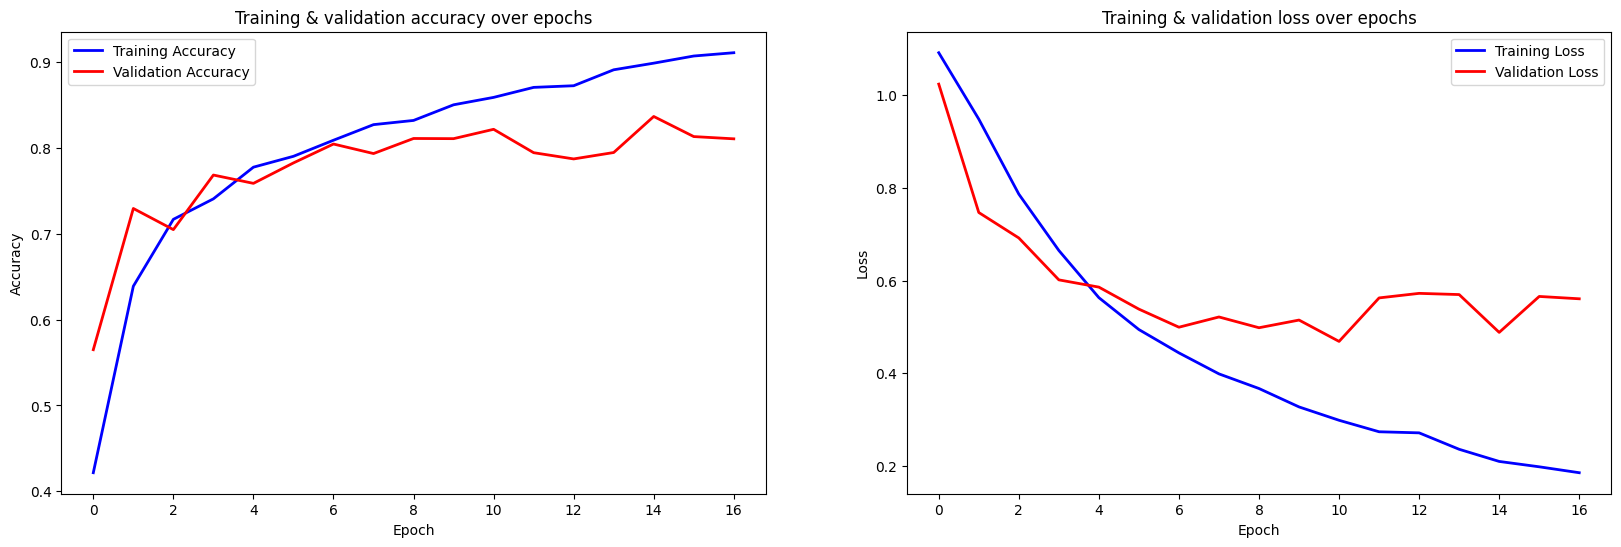

In [89]:
evaluate_model(history_RNN)

In [124]:
m = model_GRU(vocab_size, input_length=MAX_SEQ_LEN)
history_GRU = train(m, X_train, Y_train_encoded, X_val, Y_val_encoded, epochs=100, batch_size=256) 

Epoch 1/100
78/78 - 19s - 241ms/step - accuracy: 0.2623 - loss: 1.0989 - val_accuracy: 0.0625 - val_loss: 1.1019
Epoch 2/100
78/78 - 18s - 236ms/step - accuracy: 0.2790 - loss: 1.0991 - val_accuracy: 0.0625 - val_loss: 1.1018
Epoch 3/100
78/78 - 18s - 227ms/step - accuracy: 0.2863 - loss: 1.0986 - val_accuracy: 0.0625 - val_loss: 1.1011
Epoch 4/100
78/78 - 18s - 232ms/step - accuracy: 0.3070 - loss: 1.0990 - val_accuracy: 0.0627 - val_loss: 1.1007
Epoch 5/100
78/78 - 18s - 229ms/step - accuracy: 0.3003 - loss: 1.0985 - val_accuracy: 0.0627 - val_loss: 1.1002
Epoch 6/100
78/78 - 18s - 225ms/step - accuracy: 0.3114 - loss: 1.0994 - val_accuracy: 0.1699 - val_loss: 1.0989
Epoch 7/100
78/78 - 17s - 219ms/step - accuracy: 0.3246 - loss: 1.0993 - val_accuracy: 0.1715 - val_loss: 1.0984
Epoch 8/100
78/78 - 17s - 214ms/step - accuracy: 0.3193 - loss: 1.0989 - val_accuracy: 0.0627 - val_loss: 1.0986
Epoch 9/100
78/78 - 17s - 221ms/step - accuracy: 0.3200 - loss: 1.0995 - val_accuracy: 0.7658 - 

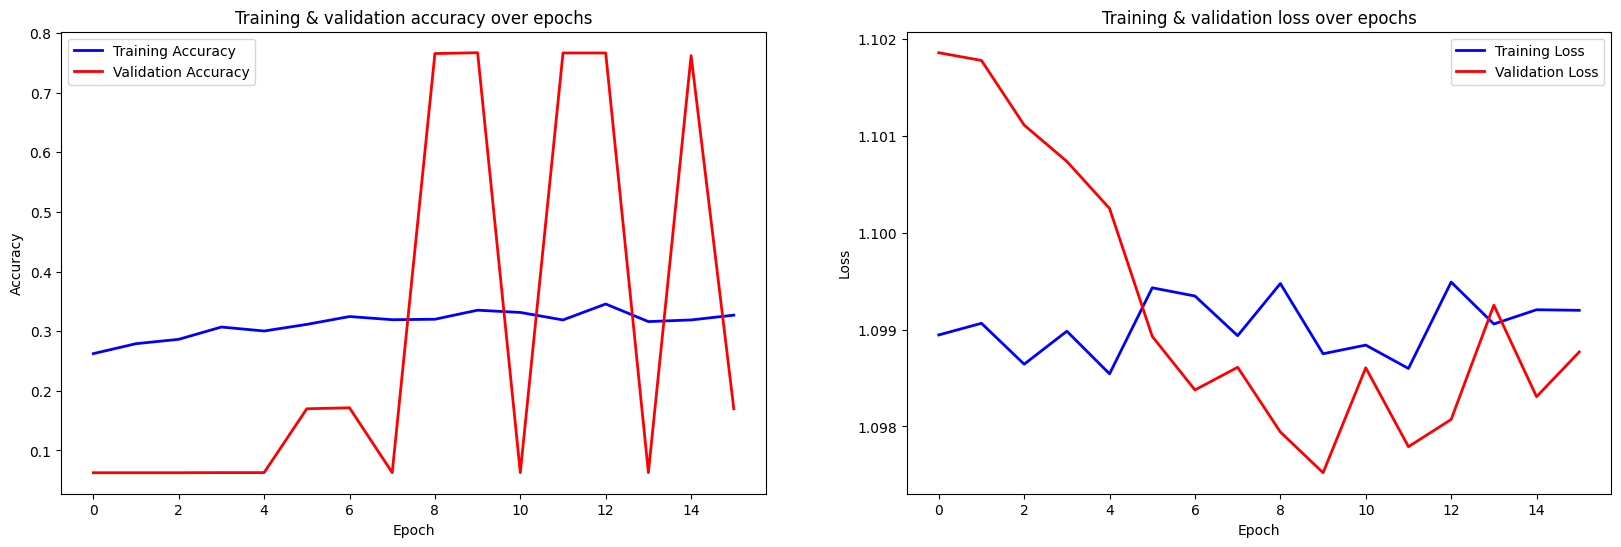

In [125]:
evaluate_model(history_GRU)

### Training of Novel Model

Epoch 1/100
39/39 - 7s - 183ms/step - accuracy: 0.3686 - loss: 1.1123 - val_accuracy: 0.3974 - val_loss: 1.0920
Epoch 2/100
39/39 - 3s - 75ms/step - accuracy: 0.3709 - loss: 1.1147 - val_accuracy: 0.4140 - val_loss: 1.0900
Epoch 3/100
39/39 - 4s - 92ms/step - accuracy: 0.3730 - loss: 1.1096 - val_accuracy: 0.4174 - val_loss: 1.0897
Epoch 4/100
39/39 - 4s - 103ms/step - accuracy: 0.3784 - loss: 1.1106 - val_accuracy: 0.4485 - val_loss: 1.0863
Epoch 5/100
39/39 - 4s - 105ms/step - accuracy: 0.3756 - loss: 1.1124 - val_accuracy: 0.4585 - val_loss: 1.0846
Epoch 6/100
39/39 - 4s - 105ms/step - accuracy: 0.3848 - loss: 1.1082 - val_accuracy: 0.4807 - val_loss: 1.0819
Epoch 7/100
39/39 - 4s - 98ms/step - accuracy: 0.3939 - loss: 1.1065 - val_accuracy: 0.4979 - val_loss: 1.0796
Epoch 8/100
39/39 - 4s - 99ms/step - accuracy: 0.3858 - loss: 1.1030 - val_accuracy: 0.4850 - val_loss: 1.0815
Epoch 9/100
39/39 - 4s - 99ms/step - accuracy: 0.3818 - loss: 1.1078 - val_accuracy: 0.4842 - val_loss: 1.08

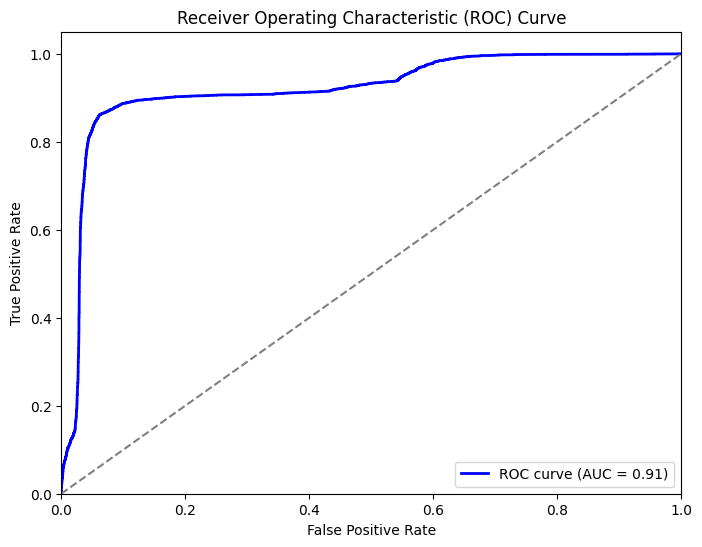

In [179]:
m = novel_model(vocab_size, input_length=MAX_SEQ_LEN, learning_rate=0.00003)
history = train(m, X_train, Y_train_encoded, X_val, Y_val_encoded, epochs=100, batch_size=512)  

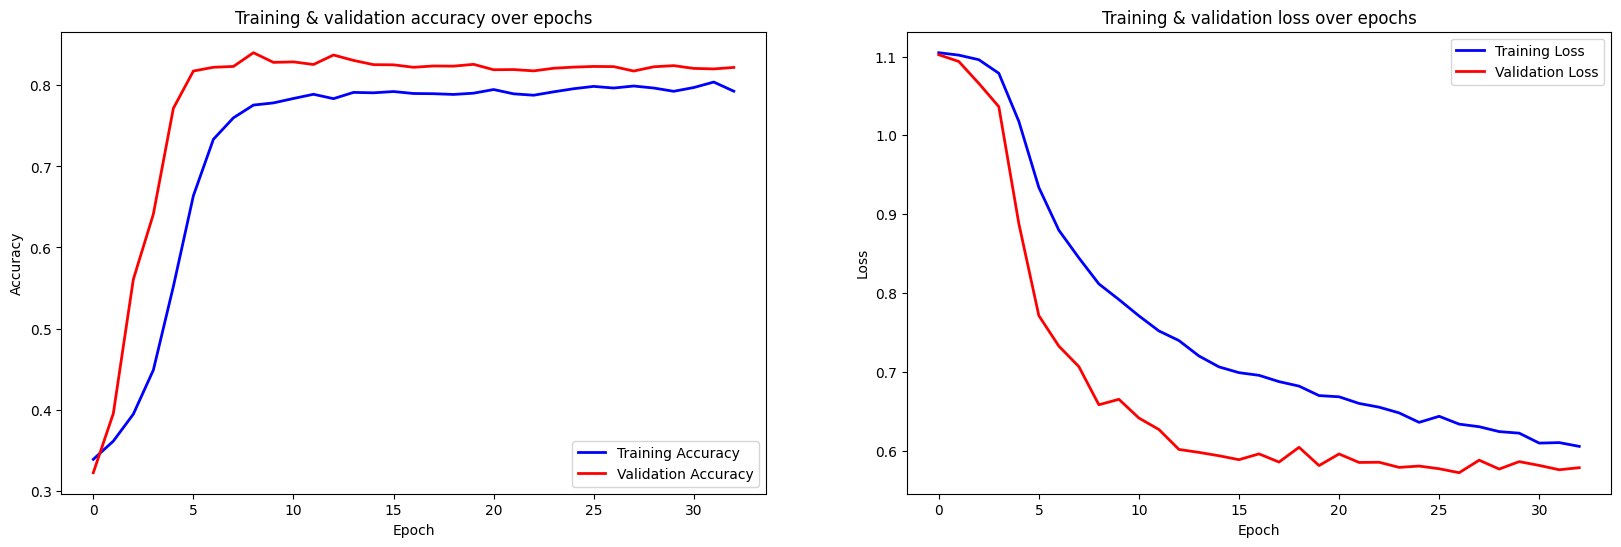

In [178]:
evaluate_model(history)